In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [4]:
DATASET_ID = 'swamp_sparrow'

In [5]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [6]:
from avgn.signalprocessing.create_spectrogram_dataset import prepare_wav, create_label_df, get_row_audio

### create dataset

In [7]:
hparams = HParams(
    num_mel_bins = 32,
    mel_lower_edge_hertz=1500,
    mel_upper_edge_hertz=10000,
    butter_lowcut = 1500,
    butter_highcut = 10000,
    ref_level_db = 20,
    min_level_db = -20,
    mask_spec = True,
    win_length_ms = 5,
    hop_length_ms = .5,
    mask_spec_kwargs = {"spec_thresh": 0.9, "offset": 1e-10}
)

In [8]:
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    6.5s


[Parallel(n_jobs=-1)]: Done 1867 out of 1867 | elapsed:    6.9s finished


In [9]:
dataset.sample_json

OrderedDict([('datetime', '2009-05-12_17-57-19'),
             ('samplerate_hz', 44100.0),
             ('indvs',
              OrderedDict([('NYHVTIV18',
                            OrderedDict([('syllables',
                                          OrderedDict([('start_time',
                                                        [0.169,
                                                         0.331,
                                                         0.5,
                                                         0.665,
                                                         0.826,
                                                         0.993,
                                                         1.157,
                                                         1.317,
                                                         1.481,
                                                         1.643,
                                                         1.808,
                  

#### Create dataset based upon JSON

In [10]:
from joblib import Parallel, delayed
n_jobs = -1; verbosity = 10

In [11]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(create_label_df)(
            dataset.data_files[key].data,
            hparams=dataset.hparams,
            dict_features_to_retain = ['POPID', 'GRIDX', 'GRIDY'],
            labels_to_retain=["syllable", "pos_in_syllable", "peakfreq_start", "peakfreq_end"],
            unit="elements",
            key = key,
        )
        for key in tqdm(dataset.data_files.keys())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1991s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 249 ta

[Parallel(n_jobs=-1)]: Done 1867 out of 1867 | elapsed:    6.6s finished


97498

In [12]:
syllable_df[:3]

,start_time,end_time,syllable,pos_in_syllable,peakfreq_start,peakfreq_end,indv,indvi,POPID,GRIDX,GRIDY,key
0,0.1705,0.2145,0.0,0.0,6158.496094,5254.101562,NYHVTIV18,0,"Hudson Valley, NY",42.042489,-73.9237463,SWSP09TIV18L1
1,0.2035,0.2550,0.0,1.0,3746.777344,4048.242188,NYHVTIV18,0,"Hudson Valley, NY",42.042489,-73.9237463,SWSP09TIV18L1
2,0.2625,0.2910,0.0,2.0,8311.816406,3875.976562,NYHVTIV18,0,"Hudson Valley, NY",42.042489,-73.9237463,SWSP09TIV18L1


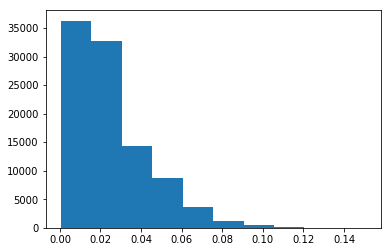

In [13]:
plt.hist(syllable_df.end_time.values - syllable_df.start_time.values);

In [14]:
#syllable_df['start_time'] = syllable_df['start_time'] - 0.025
#syllable_df['end_time'] = syllable_df['end_time'] + 0.0125
#syllable_df['end_time'] = syllable_df['end_time'] + ((syllable_df['end_time'] - syllable_df['start_time'])/8)

### get audio for dataset

In [15]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(get_row_audio)(
            syllable_df[syllable_df.key == key], 
            dataset.data_files[key].data['wav_loc'], 
            dataset.hparams
        )
        for key in tqdm(syllable_df.key.unique())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1500s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 118 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 182 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 254 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 334 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 422 ta

[Parallel(n_jobs=-1)]: Done 1790 out of 1853 | elapsed:   16.5s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 1853 out of 1853 | elapsed:   16.6s finished


97498

In [16]:
syllable_df[:3]

,start_time,end_time,syllable,pos_in_syllable,peakfreq_start,peakfreq_end,indv,indvi,POPID,GRIDX,GRIDY,key,audio,rate
0,0.1705,0.2145,0.0,0.0,6158.496094,5254.101562,NYHVTIV18,0,"Hudson Valley, NY",42.042489,-73.9237463,SWSP09TIV18L1,"[0.0012226634, 0.004951131, 0.005269252, 0.001...",44100
1,0.2035,0.2550,0.0,1.0,3746.777344,4048.242188,NYHVTIV18,0,"Hudson Valley, NY",42.042489,-73.9237463,SWSP09TIV18L1,"[0.012577064, -0.16122648, -0.23169872, -0.152...",44100
2,0.2625,0.2910,0.0,2.0,8311.816406,3875.976562,NYHVTIV18,0,"Hudson Valley, NY",42.042489,-73.9237463,SWSP09TIV18L1,"[-0.01183479, -0.02601701, -0.02904611, -0.023...",44100


In [17]:
sylls = syllable_df.audio.values

In [18]:
sylls = [i / np.max(np.abs(i)) for i in tqdm(sylls)]

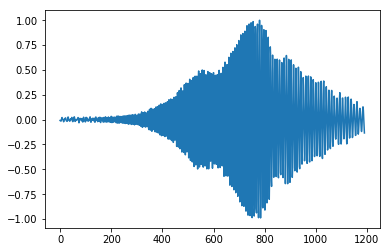

In [19]:
syll = sylls[35]
#syll = np.pad(syll, 100)
plt.plot(syll)

In [20]:
def taper_signal(signal, samps = 200):
    # ensure long enough for head and tail
    if len(signal) < (samps*2):
        samps = int(np.floor(len(signal-1)/2))
    
    # taper head and tail
    head = signal[:samps] * np.linspace(0,1, samps)
    tail = signal[-samps:] * np.linspace(0,1, samps)[::-1]
    # merge
    signal = np.concatenate([head, signal[samps:-samps], tail])
    return signal

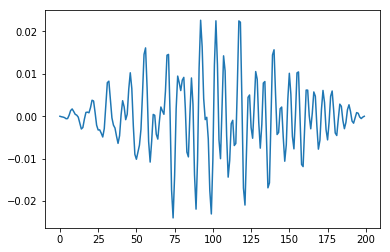

In [21]:
plt.plot(taper_signal(syll[:200], 200))

In [22]:
import IPython.display as ipd

In [23]:
ipd.Audio(data=syll, rate=44100)

In [24]:
ipd.Audio(data=taper_signal(syll), rate=44100)

In [25]:
syllable_df['audio'] = [taper_signal(syll, 30) for syll in tqdm(sylls)]

In [26]:
syllable_df['syll_len'] = [len(row.audio)/row.rate for idx, row in tqdm(syllable_df.iterrows())]

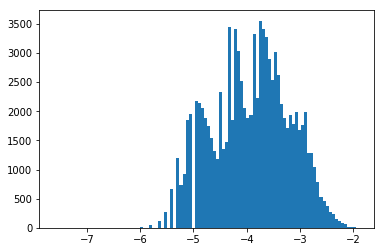

In [49]:
plt.hist(np.log(syllable_df.syll_len.values), bins = 100);

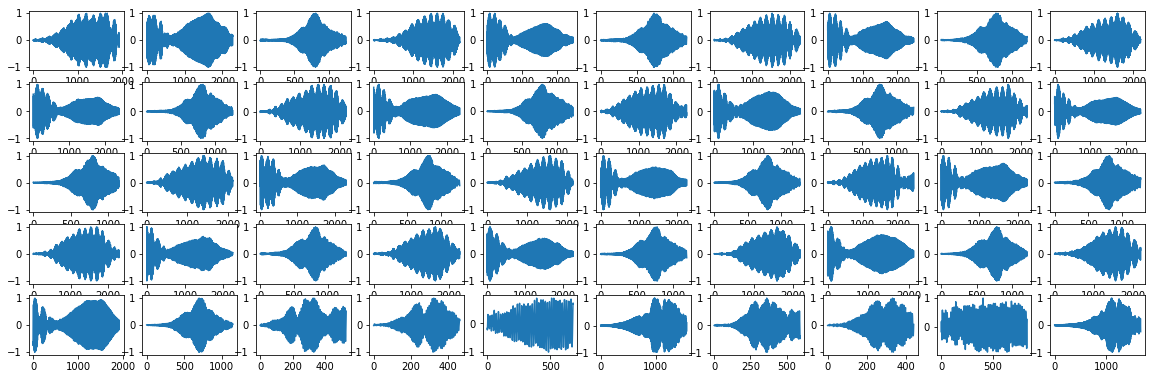

In [27]:
nrows = 5
ncols = 10
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, syll in tqdm(enumerate(sylls), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)
    if i == nrows*ncols -1:
        break

### Create spectrograms

In [28]:
from avgn.visualization.spectrogram import draw_spec_set
from avgn.signalprocessing.create_spectrogram_dataset import make_spec, mask_spec, log_resize_spec, pad_spectrogram

In [29]:
syllables_wav = syllable_df.audio.values
syllables_rate = syllable_df.rate.values

In [30]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    # create spectrograms
    syllables_spec = parallel(
        delayed(make_spec)(
            syllable,
            rate,
            hparams=dataset.hparams,
            mel_matrix=dataset.mel_matrix,
            use_mel=False,
            use_tensorflow=False,
        )
        for syllable, rate in tqdm(
            zip(syllables_wav, syllables_rate),
            total=len(syllables_rate),
            desc="getting syllable spectrograms",
            leave=False,
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0155s.) Setting batch_size=24.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1469s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 880 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1336 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2152 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3456 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 4800 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 6272 tasks      | elapsed:    2.3s
[Paral

[Parallel(n_jobs=-1)]: Done 97498 out of 97498 | elapsed:   28.7s finished


In [31]:
f_start_list = []
f_end_list = []
for spec, rate in tqdm(zip(syllables_spec, syllables_rate)):
    fmax = np.argmax(spec, axis=0)
    fmax = fmax * rate / (1024) 
    fmax_start, fmax_end = fmax[fmax!=0][[0, -1]]
    f_start_list.append(fmax_start)
    f_end_list.append(fmax_end)

In [32]:
syllable_df['f_start'] = f_start_list
syllable_df['f_end'] = f_end_list

In [33]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    # create spectrograms
    syllables_spec = parallel(
        delayed(make_spec)(
            syllable,
            rate,
            hparams=dataset.hparams,
            mel_matrix=dataset.mel_matrix,
            use_mel=True,
            use_tensorflow=False,
        )
        for syllable, rate in tqdm(
            zip(syllables_wav, syllables_rate),
            total=len(syllables_rate),
            desc="getting syllable spectrograms",
            leave=False,
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0354s.) Setting batch_size=10.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1246s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 404 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1245s.) Setting batch_size=102.
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1632 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2514 tasks      | ela

[Parallel(n_jobs=-1)]: Done 97498 out of 97498 | elapsed:   12.1s finished


### Rescale spectrogram
- using log rescaling

In [34]:
log_scaling_factor = 4

In [35]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllables_spec = parallel(
        delayed(log_resize_spec)(spec, scaling_factor=log_scaling_factor)
        for spec in tqdm(syllables_spec, desc="scaling spectrograms", leave=False)
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1683s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0662s.) Setting batch_size=12.
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0879s.) Setting batch_size=54.
[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 660 tasks      | elapsed

[Parallel(n_jobs=-1)]: Done 97498 out of 97498 | elapsed:    8.1s finished


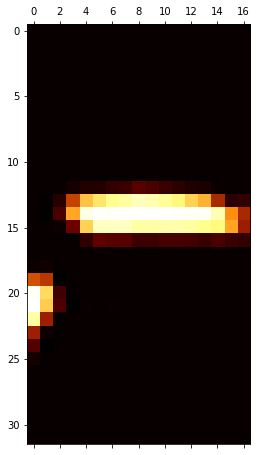

In [36]:
plt.matshow(syllables_spec[288], cmap = plt.cm.afmhot)

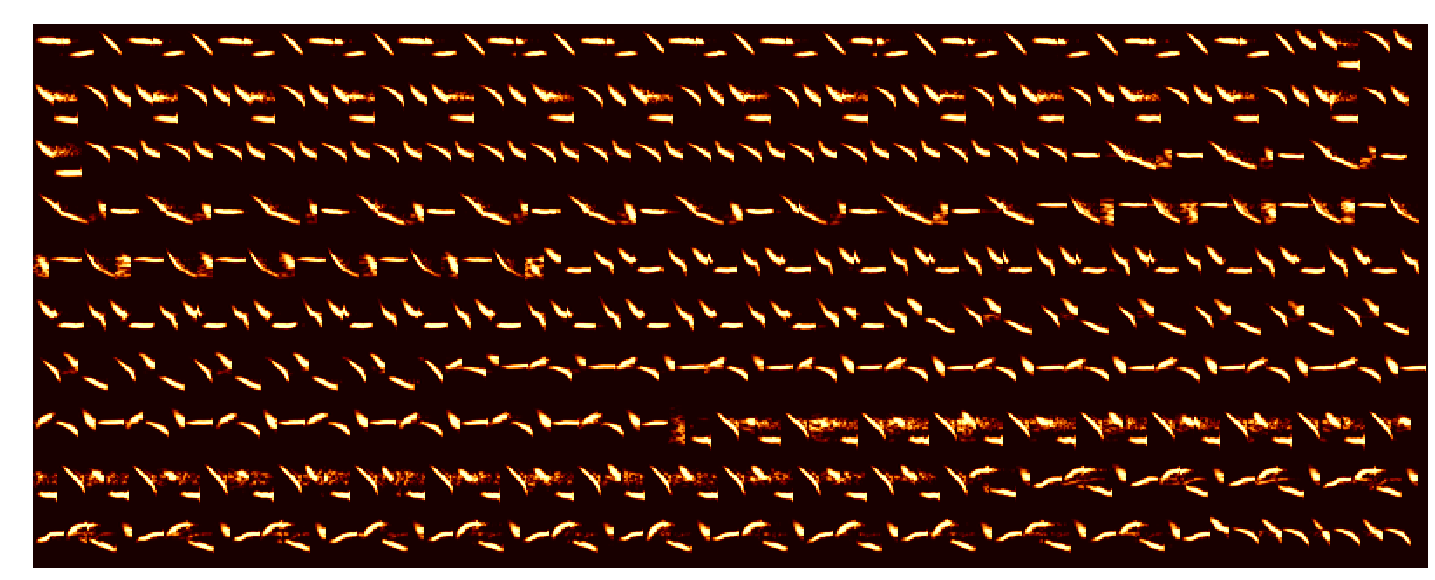

In [37]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

### Pad spectrograms

In [38]:
syll_lens = [np.shape(i)[1] for i in syllables_spec]
pad_length = np.max(syll_lens)

(array([1.0000e+00, 0.0000e+00, 6.0000e+01, 3.9140e+03, 1.5319e+04,
        1.9370e+04, 2.3140e+04, 2.1172e+04, 1.2493e+04, 2.0290e+03]),
 array([ 2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22.]),
 <a list of 10 Patch objects>)

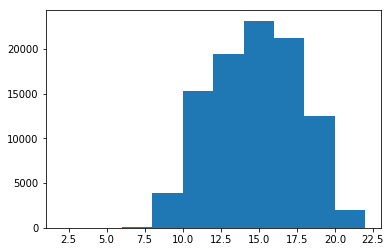

In [39]:
plt.hist(syll_lens)

In [40]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:

    syllables_spec = parallel(
        delayed(pad_spectrogram)(spec, pad_length)
        for spec in tqdm(
            syllables_spec, desc="padding spectrograms", leave=False
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0215s.) Setting batch_size=18.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0870s.) Setting batch_size=82.
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 676 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1039s.) Setting batch_size=314.
[Parallel(n_jobs=-1)]: Done 1082 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1872 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 3594 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8564 tasks      | e

[Parallel(n_jobs=-1)]: Done 97498 out of 97498 | elapsed:    7.1s finished


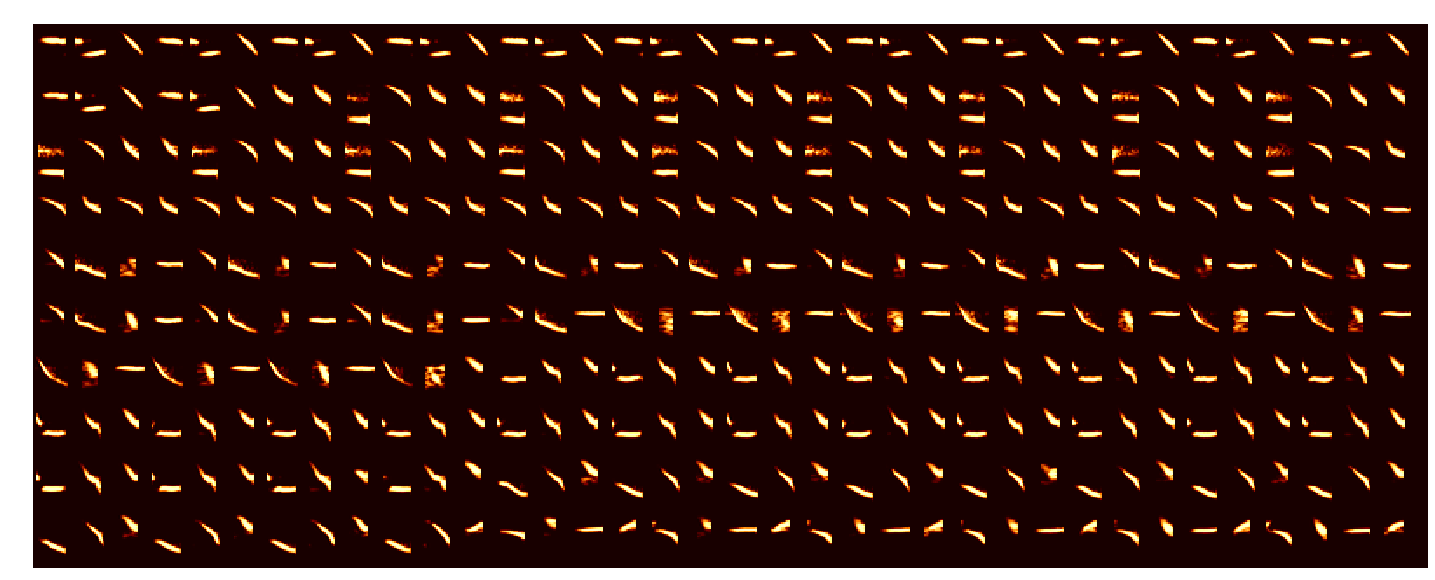

In [41]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

### save dataset

In [42]:
np.shape(syllables_spec)

(97498, 32, 22)

In [43]:
syllable_df[:3]

,start_time,end_time,syllable,pos_in_syllable,peakfreq_start,peakfreq_end,indv,indvi,POPID,GRIDX,GRIDY,key,audio,rate,syll_len,f_start,f_end
0,0.1705,0.2145,0.0,0.0,6158.496094,5254.101562,NYHVTIV18,0,"Hudson Valley, NY",42.042489,-73.9237463,SWSP09TIV18L1,"[0.0, 0.0005278791589983579, 0.001123593156707...",44100,0.043991,5857.031250,6287.695312
1,0.2035,0.2550,0.0,1.0,3746.777344,4048.242188,NYHVTIV18,0,"Hudson Valley, NY",42.042489,-73.9237463,SWSP09TIV18L1,"[0.0, -0.015641441632961404, -0.04495665944855...",44100,0.051497,5469.433594,4220.507812
2,0.2625,0.2910,0.0,2.0,8311.816406,3875.976562,NYHVTIV18,0,"Hudson Valley, NY",42.042489,-73.9237463,SWSP09TIV18L1,"[-0.0, -0.001130732482877271, -0.0025247620611...",44100,0.028503,7795.019531,3919.042969


In [44]:
syllable_df['spectrogram'] = syllables_spec

In [45]:
save_loc = DATA_DIR / 'syllable_dfs' / DATASET_ID / 'swampsparrow-taper_with_freq.pickle'
ensure_dir(save_loc)
syllable_df.to_pickle(save_loc)